In [1]:
'''
MNIST data setup
'''

from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [2]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

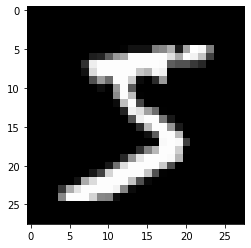

(50000, 784)


In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()
print(x_train.shape)

In [5]:
'''numpy array to torch tensor'''
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [ ]:
x_train, x_train.shape, y_train.min(), y_train.max()

In [6]:
'''GPU Using'''
print(torch.cuda.is_available())

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [7]:
import torch.nn.functional as F

loss_func = F.cross_entropy

In [8]:
import torch.nn as nn

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features= nn.Sequential(
            # 1
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 3
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 4
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 
            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False),
            # 5
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 6
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 7
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2, dilation=1, ceil_mode=False),
            # 8
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 9
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #
            nn.AvgPool2d(kernel_size=7),
        )
        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.features(x)
        x = x.view(x.size(0), 256)
        x = self.classifier(x)
        return x
    

In [101]:
model = Mnist_CNN()
model.to(device)

Mnist_CNN(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride

In [102]:
from torch import optim
lr = 0.01  # learning rate
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [103]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

bs = 64
'''
1024: 0.9924744248390198
512: 0.9911670923233032
256: 0.9946633726358414
128 - 0.005: 0.99541015625
128 - 0.01: 0.98955078125
64: 0.9888251582278481

'''


train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [104]:
epochs = 30  # how many epochs to train for

g_losses, g_accuracies, g_valid_losses, g_valid_accuracies = [], [], [], []

def fit():
    for epoch in range(epochs):
        model.train()
        losses = []
        accuracies = []
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)

            pred = model(xb)
            loss = loss_func(pred, yb)

            with torch.no_grad():
                losses.append(loss.cpu().item())
                accuracies.append((torch.argmax(pred, dim=1) == yb).cpu().float().mean().item())

            loss.backward()
            opt.step()
            opt.zero_grad()

        '''Validation'''
        model.eval()
        with torch.no_grad():
            valid_losses = []
            valid_accuracies = []
            for xb, yb in valid_dl:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                valid_losses.append(loss_func(pred, yb).cpu().item())
                valid_accuracies.append((torch.argmax(pred, dim=1) == yb).cpu().float().mean().item())
        print(epoch, np.average(losses), "\t", np.average(accuracies), "\t", np.average(valid_losses), "\t", np.average(valid_accuracies))
        g_losses.append(np.average(losses))
        g_accuracies.append(np.average(accuracies))
        g_valid_losses.append(np.average(valid_losses))
        g_valid_accuracies.append(np.average(valid_accuracies))
        
        '''
        if (epoch + 1) % (epochs // epochs) == 0:
            fig, ax1 = pyplot.subplots()

            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.plot(g_losses, label="train loss", color='tab:orange')
            ax1.plot(g_valid_losses, label="valid loss", color='tab:red')

            ax2 = ax1.twinx()
            ax2.set_ylabel('accuracy')
            ax2.plot(g_accuracies, label="train accuracy", color='tab:purple')
            ax2.plot(g_valid_accuracies, label="valid accuracy", color='tab:blue')

            pyplot.show()
        '''


fit()

0 0.1428951607853927 	 0.9629355818414322 	 0.08066593041596344 	 0.9766613924050633
1 0.03258667791680888 	 0.9902293797953964 	 0.03237886449964599 	 0.991495253164557
2 0.02287210145769605 	 0.9932864450127877 	 0.024849978055660554 	 0.991495253164557
3 0.019274608227614877 	 0.9945052749360613 	 0.022479809495720635 	 0.9931764240506329
4 0.014082213105728238 	 0.9954044117647058 	 0.032534398312777685 	 0.9895174050632911
5 0.011565728971655444 	 0.9966632033248082 	 0.021584780852692026 	 0.993868670886076
6 0.012056472021221456 	 0.9961836636828645 	 0.03513973153434263 	 0.9902096518987342
7 0.008351783451801814 	 0.9974224744245525 	 0.02318933573304646 	 0.9933742088607594
8 0.00545999893671958 	 0.9984414961636828 	 0.0147454740939954 	 0.9956487341772152
9 0.003956773198278406 	 0.9989809782608695 	 0.017361989067778062 	 0.9949564873417721
10 0.004648288612712405 	 0.9987811700767263 	 0.024227839383663966 	 0.9921875
11 0.002914967773201735 	 0.9992607097186701 	 0.01443

In [107]:
from torchsummary import summary

print(summary(model, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             576
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
            Conv2d-4          [-1, 128, 28, 28]          73,728
       BatchNorm2d-5          [-1, 128, 28, 28]             256
              ReLU-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         147,456
       BatchNorm2d-8          [-1, 128, 28, 28]             256
              ReLU-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 128, 28, 28]         147,456
      BatchNorm2d-11          [-1, 128, 28, 28]             256
             ReLU-12          [-1, 128, 28, 28]               0
        MaxPool2d-13          [-1, 128, 14, 14]               0
           Conv2d-14          [-1, 128,

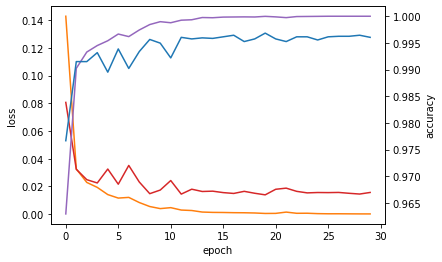

In [105]:
fig, ax1 = pyplot.subplots()

ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.plot(g_losses, label="train loss", color='tab:orange')
ax1.plot(g_valid_losses, label="valid loss", color='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy')
ax2.plot(g_accuracies, label="train accuracy", color='tab:purple')
ax2.plot(g_valid_accuracies, label="valid accuracy", color='tab:blue')

pyplot.show()

In [106]:
torch.save(model.state_dict(), "trained_model/pnet200829.pth")